# Randomise papers

Describes random selection of papers for inclusion in the review

Saoirse Kelleher  
November 27, 2023

## Overview

As this review evolved, two samples of target papers were acquired from two distinct sampling protocols.

-   The **First Sample** was acquired in October 2021 from Google Scholar. The first 100 hits for each of four search terms (‘dynamic occupancy model,’ ‘occupancy dynamics model,’ ‘multi-season occupancy model,’ and ‘stochastic patch occupancy model’, plus allowances for pluralisation) were downloaded. These were stratified by their query and year-window (2000-2005, 2006-2010, 2010-2015, and 2016-2021). A random sample of 25% of the strata *or* 5 papers, whichever was larger, was flagged for inclusion in the review, to be replaced from the same strata if inclusion criteria were not met.

-   After reviewing this initial sample, the need for a **Second Sample** was identified as many of the papers included in the first did not represent our model of interest. This second, more narrowly targeted sample was drawn from papers citing MacKenzie et al. ([2003](#ref-mackenzie2003)), the original description of the model class which all subsequent implementations would be expected to cite. Papers were acquired via Web of Science in September 2023. The same 4 year-window strata were used here, with 15 papers randomly drawn from each strata. A fifth strata was added for 2022-2023, to capture the most recent papers on these models.

For transparency and reproducibility, the randomisation code is preserved in this document.

## First sample

The full list of papers acquired from the aforementioned queries is read into R, and each is assigned to a year-window.

In [ ]:
library("knitr")
library("tidyverse") 


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

  -------------------------------------------------------------------------------------------------
  Review_ID   Query       Title                                                 Year   YearPeriod
  ----------- ----------- ----------------------------------------------------- ------ ------------
  6           Dynamic     Single-visit dynamic occupancy models: an approach to 2017   2016:2021
              occupancy   account for imperfect detection with Atlas data              
              model                                                                    

  7           Dynamic     A dynamic occupancy model for interacting species     2020   2016:2021
              occupancy   with two spatial scales                                      
              model                                                                    

  8           Dynamic     A multistate dynamic occupancy model to estimate      2019   2016:2021
              occupancy   local colonization--extinction rates and patterns of         
              model       co‐occurrence between two or more interacting species        

  9           Dynamic     Neural hierarchical models of ecological populations  2019   2016:2021
              occupancy                                                                
              model                                                                    

  11          Dynamic     Unravelling the drastic range retraction of an        2017   2016:2021
              occupancy   emblematic songbird of North Africa: potential               
              model       threats to Afro-Palearctic migratory birds                   

  12          Dynamic     Detecting dispersal: A spatial dynamic occupancy      2021   2016:2021
              occupancy   model to reliably quantify connectivity across               
              model       heterogeneous conservation landscapes                        
  -------------------------------------------------------------------------------------------------


A random number is then assigned to *all* papers. Papers are then ranked by number within their year-window/query strata. Papers in the top 5/25% (whichever was larger) were flagged to be read, and the rest were kept available for replacement of papers which may fail to meet inclusion criteria.

In [ ]:
# Randomly rank papers, then rank within the strata
first_rankedPapers <- first_paperList %>%
  # Add random ranks for all papers
  mutate(randRank = sample(x = 1:nrow(.), size = nrow(.))) %>%
  # Re-rank within strata
  group_by(Query, YearPeriod) %>%
  arrange(Query, YearPeriod, randRank) %>%
  mutate(GroupRank = row_number()) %>%
# Identify which papers qualify to be read
  group_by(Query, YearPeriod) %>%
  mutate(PercentRank =  GroupRank/max(GroupRank)) %>%
  mutate(ToRead = case_when(
    # If there are fewer than 5, read them all
    max(GroupRank) <= 5 ~ "YES",
    # If there are 20 or fewer, read the top 5
    max(GroupRank) <= 20 & GroupRank <= 5 ~ "YES",
    max(GroupRank) <= 20 & GroupRank >= 5 ~ "NO",
    # If there are 21 or more, read the top 25%
    max(GroupRank) >= 21 & PercentRank <= 0.25  ~ "YES",
    max(GroupRank) >= 21 & PercentRank > 0.25 ~ "NO")) %>%
  ungroup() %>%
  unite(col = Group, c(Query, YearPeriod)) %>%
  # Get Review_ID, GroupRank, and ToRead
  select(Review_ID, Title, Group, OverallRank = randRank, GroupRank, ToRead)

head(first_rankedPapers) %>%
  kable()


  ----------------------------------------------------------------------------------------------------------------
  Review_ID   Title                                           Group               OverallRank   GroupRank ToRead
  ----------- ----------------------------------------------- ----------------- ------------- ----------- --------
  51          Dealing with uncertainty in amphibian and       Dynamic occupancy            30           1 YES
              reptile population monitoring for conservation  model_2006:2010                             

  69          A BAYESIAN STATE-SPACE FORMULATION OF DYNAMIC   Dynamic occupancy            82           2 YES
              OCCUPANCY MODELS                                model_2006:2010                             

  63          Occurrence patterns of Black-backed Woodpeckers Dynamic occupancy            57           1 YES
              in green forest of the Sierra Nevada Mountains, model_2011:2015                             
              California, USA.                                                                            

  50          Individual and population-level responses of    Dynamic occupancy            67           2 YES
              the Alabama beach mouse (Peromyscus polionotus  model_2011:2015                             
              ammobates) to environmental variation in space                                              
              and time                                                                                    

  59          Effects of Urbanization on Occupancy of Stream  Dynamic occupancy            69           3 YES
              Salamanders: Salamander Occupancy and           model_2011:2015                             
              Urbanization                                                                                

  39          Coffee Agroforests Remain Beneficial for        Dynamic occupancy            70           4 YES
              Neotropical Bird Community Conservation across  model_2011:2015                             
              Seasons                                                                                     
  ----------------------------------------------------------------------------------------------------------------


Incidental papers which were not ranked are returned to the dataframe, and the output is saved.

In [ ]:
first_unrankedPapers <- first_paperList %>% 
  # Drop empty rows, excluded, and incidental papers
  filter(is.na(Query) | Query == "INCIDENTAL" | Year == "EXCLUDE") %>%
  mutate(ToRead = "NO", Group = "Unranked", GroupRank = "NA", OverallRank = "NA") %>%
  select(Review_ID, Title, Group, OverallRank, GroupRank, ToRead)

# Combine ranked and unranked papers
firstSample <- rbind(first_rankedPapers, first_unrankedPapers) %>%
  mutate(Review_ID = as.numeric(Review_ID)) %>%
  arrange(Review_ID) %>%
  mutate(Sample = "First")

# Write to disk
write_csv(firstSample, file = "Randomisation/FirstSampleRanks.csv")


## Second sample

The list of papers pulled from Web of Science is loaded in - 1184 papers are represented here. Year-windows are assigned here as in the **First Sample.**

In [ ]:
# Load query and extract relevant columns
second_Query <- readxl::read_xls("Queries/MacKenzie WOS/MacKenzie03.xls") %>%
  select(Review_ID, Title = `Article Title`, Year = `Publication Year`) %>%
  # Assign year period
  mutate(YearPeriod = case_when(Year %in% 2000:2005 ~ "2000:2005",
                                Year %in% 2006:2010 ~ "2006:2010",
                                Year %in% 2011:2015 ~ "2011:2015",
                                Year %in% 2016:2021 ~ "2016:2021",
                                Year %in% 2022:2023 ~ "2022:2023"))


  --------------------------------------------------------------------------------------------
    Review_ID Title                                                          Year YearPeriod
  ----------- ------------------------------------------------------------ ------ ------------
          300 Estimating the effects of land abandonment on mammal           2023 2022:2023
              communities in the Karoo region of South Africa                     

          301 Occupancy of Bombus affinis (Hymenoptera: Apidae) in           2023 2022:2023
              Minnesota is highest in developed areas when standardized           
              surveys are employed                                                

          302 Climate casualties or human disturbance? Shrinking             2023 2022:2023
              distribution of the three large carnivores in the Greater           
              Himalaya                                                            

          303 Nonparametric Identifiability in Species Distribution and      2023 2022:2023
              Abundance Models: Why it Matters and How to Diagnose a Lack         
              of it Using Simulation                                              

          304 Variation in flight characteristics associated with entry by   2023 2022:2023
              eagles into rotor-swept zones of wind turbines                      

          305 Passive acoustic monitoring using smartphones reveals an       2023 2022:2023
              alarming gibbon decline in a protected area in the central          
              Annamite Mountains, Vietnam                                         
  --------------------------------------------------------------------------------------------


Papers are assigned a random number and ranked within their groups, and top-15 papers are flagged to be read. The output is saved for future reference.

In [ ]:
secondSample <- second_Query %>%
  # Add query flag to match with the first sample
  mutate(Query = "MacKenzie Cited") %>%
  # Add random ranks for all papers
  mutate(randRank = sample(x = 1:nrow(.), size = nrow(.))) %>%
  # Re-rank within strata
  group_by(Query, YearPeriod) %>%
  arrange(Query, YearPeriod, randRank) %>%
  mutate(GroupRank = row_number()) %>% 
  mutate(ToRead = case_when(
    GroupRank <= 15 ~ "YES",
    GroupRank >15 ~ "NO")) %>%
  unite(col = Group, c(Query, YearPeriod)) %>%
  mutate(Sample = "Second") %>%
  # Get Review_ID, GroupRank, and ToRead
  select(Sample, Review_ID, Title, Group, OverallRank = randRank, GroupRank, ToRead)
  
write_csv(secondSample, "Randomisation/SecondSampleRanks.csv")

head(secondSample) %>%
  kable()


  -------------------------------------------------------------------------------------------------------------------------
  Sample     Review_ID Title                                           Group               OverallRank   GroupRank ToRead
  -------- ----------- ----------------------------------------------- ----------------- ------------- ----------- --------
  Second          1479 Using counts to simultaneously estimate         MacKenzie                    18           1 YES
                       abundance and detection probabilities in a      Cited_2000:2005                             
                       salamander community                                                                        

  Second          1481 Declining amphibian populations: The pitfalls   MacKenzie                    37           2 YES
                       of count data in the study of diversity,        Cited_2000:2005                             
                       distributions, dynamics, and demography                                                     

  Second          1461 Influence of the temporal resolution of data on MacKenzie                    78           3 YES
                       the success of indicator species models of      Cited_2000:2005                             
                       species richness across multiple taxonomic                                                  
                       groups                                                                                      

  Second          1455 Modeling spatial trends in estimated species    MacKenzie                   204           4 YES
                       richness using breeding bird survey data: A     Cited_2000:2005                             
                       valuable tool in biodiversity assessment                                                    

  Second          1467 A field-based evaluation of a presence-absence  MacKenzie                   284           5 YES
                       protocol for monitoring ecoregional-scale       Cited_2000:2005                             
                       biodiversity                                                                                

  Second          1469 Monitoring distributions using call surveys:    MacKenzie                   366           6 YES
                       estimating site occupancy, detection            Cited_2000:2005                             
                       probabilities and inferring absence                                                         
  -------------------------------------------------------------------------------------------------------------------------


## Sample summary

A basic representation of the two sample’s coverage is presented here. The data presented is from after randomisation, **not** after reviewing, and thus does not represent the final coverage of the review as some papers may be excluded.

### First sample categories

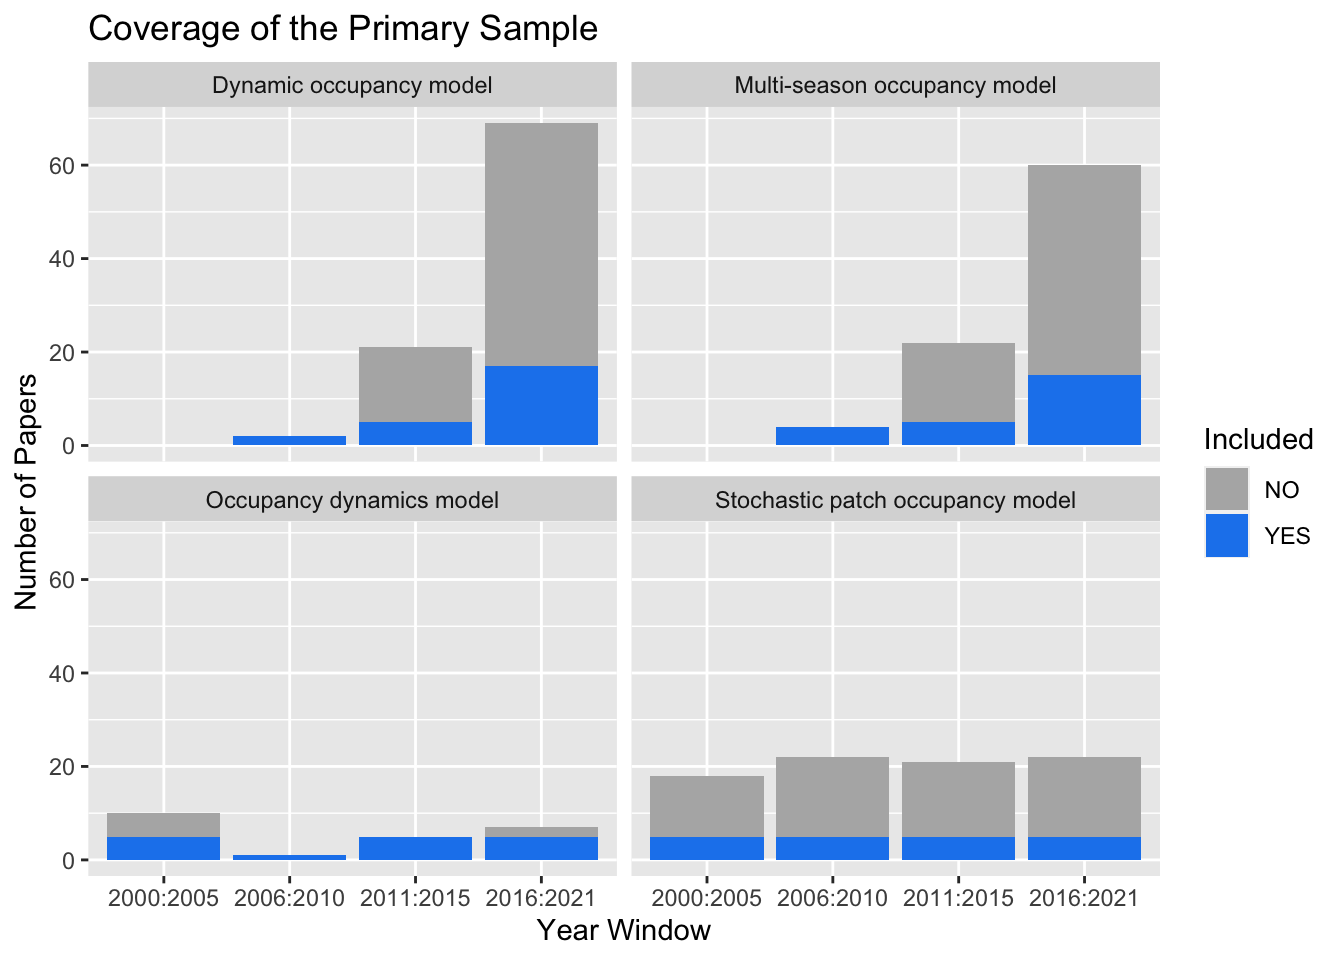

In [ ]:
firstSample %>%
  separate(Group, c("Query", "YearWindow"), sep = "_") %>%
  
  ggplot() +
  geom_bar(aes(x = YearWindow, fill = ToRead)) +
  scale_fill_manual(values = c("gray70", "dodgerblue2")) +
  facet_wrap(vars(Query), nrow = 2) +
  labs(title = "Coverage of the Primary Sample",
       y = "Number of Papers",
       x = "Year Window",
       fill = "Included")


### Second sample categories

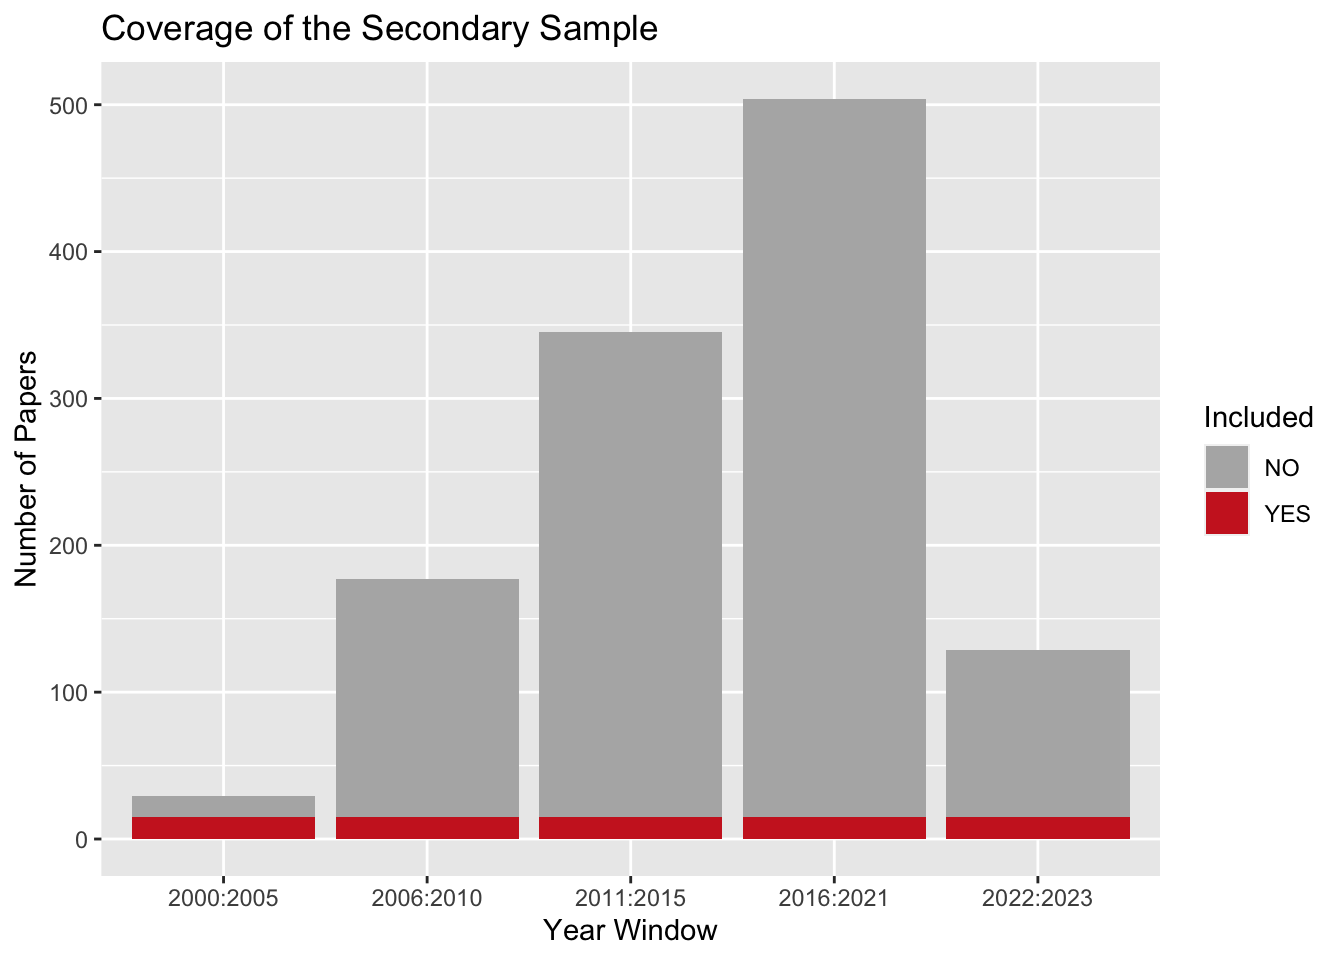

In [ ]:
secondSample %>%
  separate(Group, c("Query", "YearWindow"), sep = "_") %>%
  
  ggplot() +
  geom_bar(aes(x = YearWindow, fill = ToRead)) +
  scale_fill_manual(values = c("gray70", "firebrick3")) +
  labs(title = "Coverage of the Secondary Sample",
       y = "Number of Papers",
       x = "Year Window",
       fill = "Included")


### Combined sample

Adding the second sample improves coverage across the review period, particularly in the first two year-windows where fewer papers were included in the first sample.

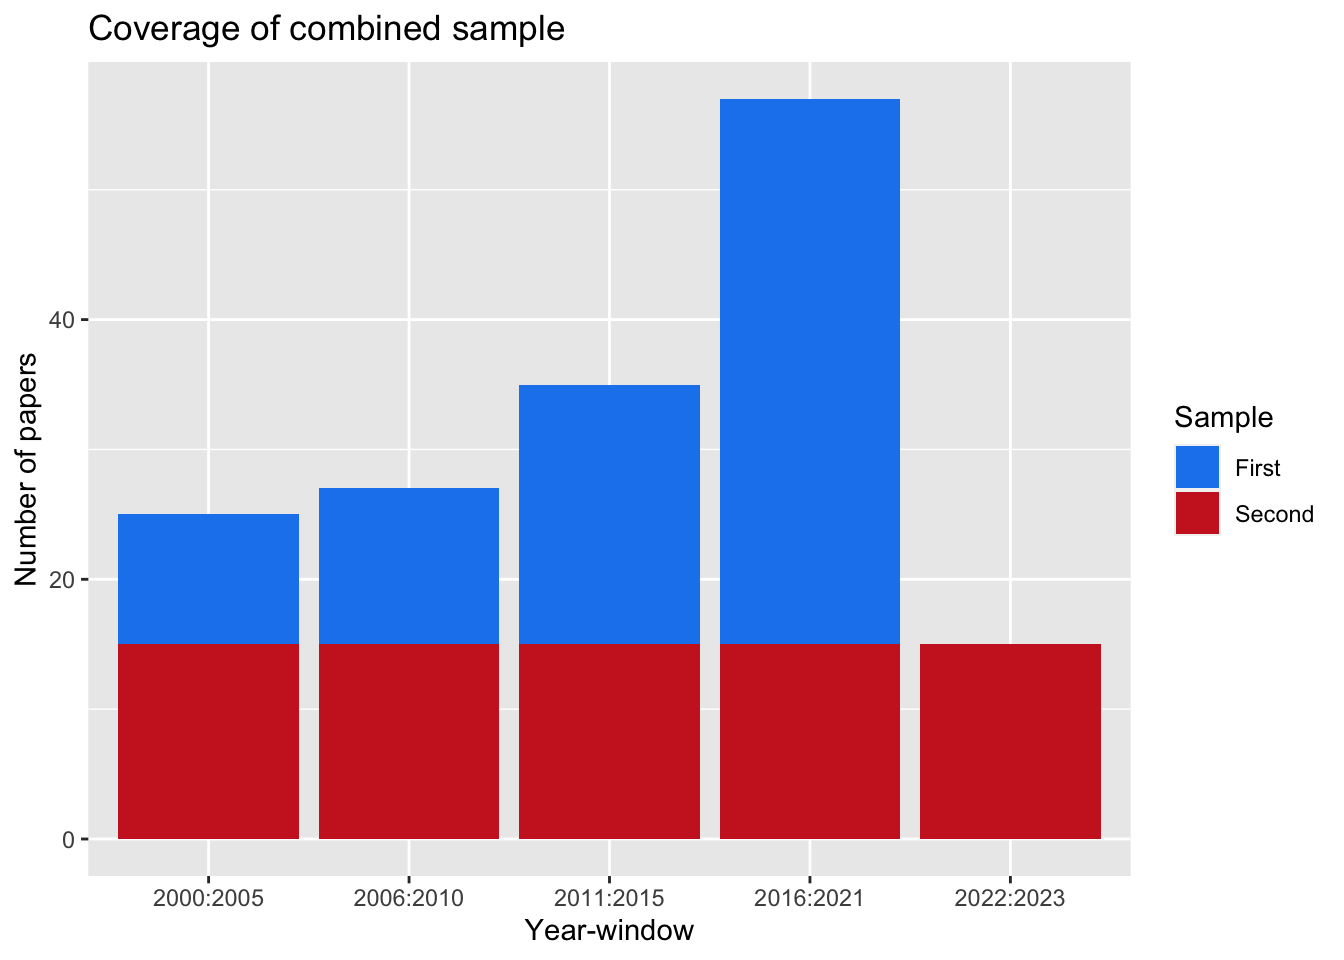

In [ ]:
rbind(firstSample, secondSample) %>%
  separate(Group, c("Query", "YearWindow"), sep = "_") %>%
  filter(ToRead == "YES") %>%
  
  ggplot() +
  geom_bar(aes(x = YearWindow, fill = Sample)) +
  scale_fill_manual(values = c("dodgerblue2", "firebrick3")) +
  labs(title = "Coverage of combined sample",
       y = "Number of papers",
       x = "Year-window")


## References

MacKenzie, Darryl I., James D. Nichols, James E. Hines, Melinda G. Knutson, and Alan B. Franklin. 2003. “ESTIMATING SITE OCCUPANCY, COLONIZATION, AND LOCAL EXTINCTION WHEN A SPECIES IS DETECTED IMPERFECTLY.” *Ecology* 84 (8): 2200–2207. <https://doi.org/10.1890/02-3090>.